In [1]:
import numpy as np
import pandas as pd
from superlink.superlink import SuperLink
from data_2 import *
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('husl')
%matplotlib inline

In [2]:
superjunctions = pd.DataFrame.from_dict(superjunctions, orient='index')
superlinks = pd.DataFrame.from_dict(superlinks, orient='index')
links = pd.concat({k: pd.DataFrame.from_dict(v, orient='index')
                   for k,v in links.items()}, axis=0)
junctions = pd.concat({k: pd.DataFrame.from_dict(v, orient='index')
                       for k,v in junctions.items()}, axis=0)

links = links.reset_index().set_index('level_1')
junctions = junctions.reset_index().set_index('level_1')

superjunctions['h_0'] += 1e-5
junctions['h_0'] += 1e-5
links['Q_0'] += 0

In [3]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, dt=1e-6)    

In [4]:
t = 0
dt = 30
dHdt = 1 / 60 / 60
bc = superlink.bc.astype(float)
H_bc = np.copy(superlink.H_j)
Q_0j = np.zeros(H_bc.size)
h = {}
H = {}
Qu = {}
Qd = {}
ts = []
Qins = []
Hbs = []

for _ in range(2 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    superlink.step(H_bc=H_bc, dt=dt)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)
    
dHdt = -2.5 / 240 / 60
dQdt = np.array([0.5, 0, 0.3, 0, 0, 0]) / 60 / 60

for _ in range(1 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j + dQdt * dt
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

for _ in range(1 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    Q_0j = Q_0j - dQdt * dt
    superlink.step(H_bc=H_bc, dt=dt, Q_0j=Q_0j)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)
    
for _ in range(2 * 3600 // dt):
    t += dt
    ts.append(t)
    H_bc = H_bc + bc * dHdt * dt
    superlink.step(H_bc=H_bc, dt=dt)
    h[t] = np.copy(superlink._h_Ik)
    H[t] = superlink.H_j
    Qu[t] = superlink._Q_uk
    Qd[t] = superlink._Q_dk
    Hbs.append(H_bc)
    Qins.append(Q_0j)

/Users/mdbartos/Git/superlink/superlink/superlink.py:223: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [5]:
Q = (np.vstack(Qu.values()) + np.vstack(Qd.values())) / 2

In [6]:
H = np.vstack(H.values())

In [7]:
ts = np.asarray(ts)

In [8]:
Qin = np.vstack(Qins)

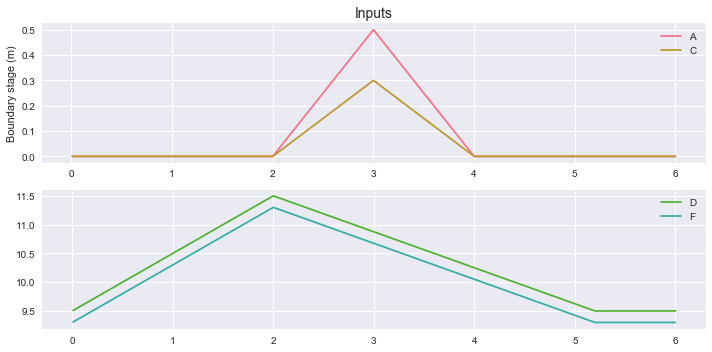

In [9]:
fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].plot(ts / 3600, Qin[:,0], label='A')
ax[0].plot(ts / 3600, Qin[:,2], label='C')
ax[0].set_title('Inputs')
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot([0], [10])
ax[1].plot([0], [10])
ax[1].plot(ts / 3600, H[:,3], label='D')
ax[1].plot(ts / 3600, H[:,5], label='F')
ax[0].set_title('Inputs', size=14)
ax[0].set_ylabel('Boundary stage (m)')
ax[1].legend()
plt.tight_layout()

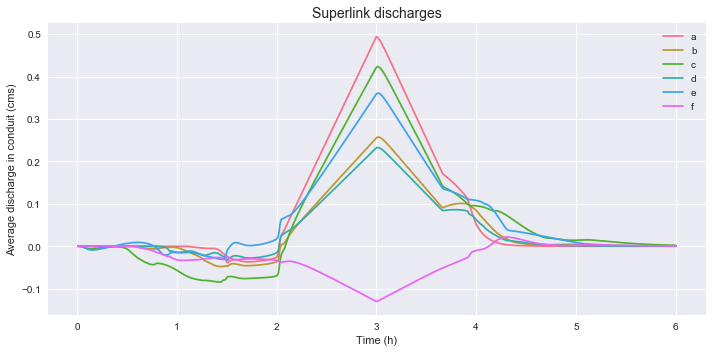

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(ts / 3600, Q[:,0], label='a')
plt.plot(ts / 3600, Q[:,1], label='b')
plt.plot(ts / 3600, Q[:,2], label='c')
plt.plot(ts / 3600, Q[:,3], label='d')
plt.plot(ts / 3600, Q[:,4], label='e')
plt.plot(ts / 3600, Q[:,5], label='f')
plt.title('Superlink discharges', size=14)
plt.xlabel('Time (h)')
plt.ylabel('Average discharge in conduit (cms)')
plt.legend()
plt.tight_layout()

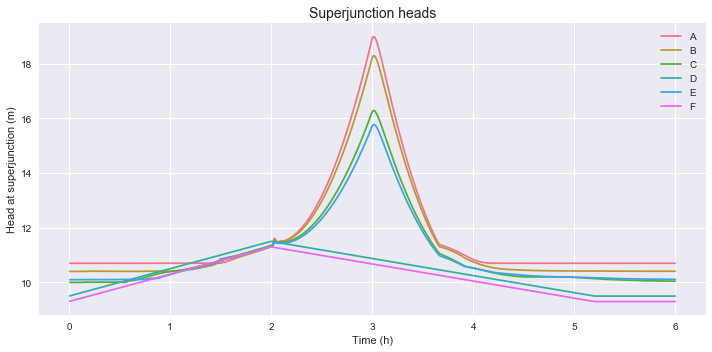

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(ts / 3600, H[:,0], label='A')
plt.plot(ts / 3600, H[:,1], label='B')
plt.plot(ts / 3600, H[:,2], label='C')
plt.plot(ts / 3600, H[:,3], label='D')
plt.plot(ts / 3600, H[:,4], label='E')
plt.plot(ts / 3600, H[:,5], label='F')
plt.title('Superjunction heads', size=14)
plt.xlabel('Time (h)')
plt.ylabel('Head at superjunction (m)')
plt.legend()
plt.tight_layout()